In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

OK, first, let's load up the light curve.

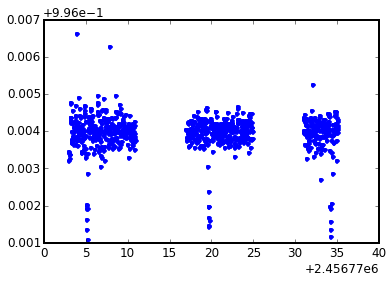

In [2]:
t, f = np.loadtxt('k2_full.txt', unpack=True)
#m = np.absolute(t) < 1.5
#t=t[m]; f=f[m]; f_err=f_err[m]
f_err = 0.00026*np.ones_like(f)
plt.plot(t, f, '.');
#plt.xlim(2.45677e6 + 4.5, 2.45677e6+5.5)

[note: In order to run the following, you have to have my [`transitfit`](http://github.com/timothydmorton/transit-fitting) package installed, as well as my fork of DFM's [`transit`](http://github.com/timothydmorton/transit) package (`autodiff-tdm` branch).]

In [3]:
from transitfit import LightCurve, Planet, TransitModel

# Here, I am initializing planet with priors on period, epoch 
#  a factor of 10 more generous than the reported values in the paper,
#  in order to be able to fit for it.
epoch = 2454833 + 1942.1659 # from paper
planet = Planet((14.5665,0.02), (epoch, 0.02), 4.73/24)

lc = LightCurve(t, f, f_err, texp=1626./86400, planets=[planet],
               detrend=False, rhostar=(3.92,1.43), 
               dilution=(0.01, 0.005)) #rhostar, dilution from paper
mod = TransitModel(lc, fix_zp=True, width=3)

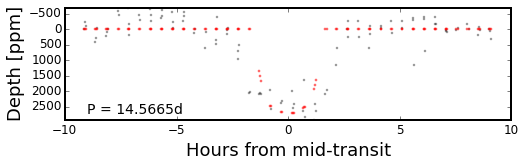

In [4]:
pars = lc.default_params
mod.plot_planets(pars);

In [5]:
mod.fit_emcee(nburn=300, niter=100);

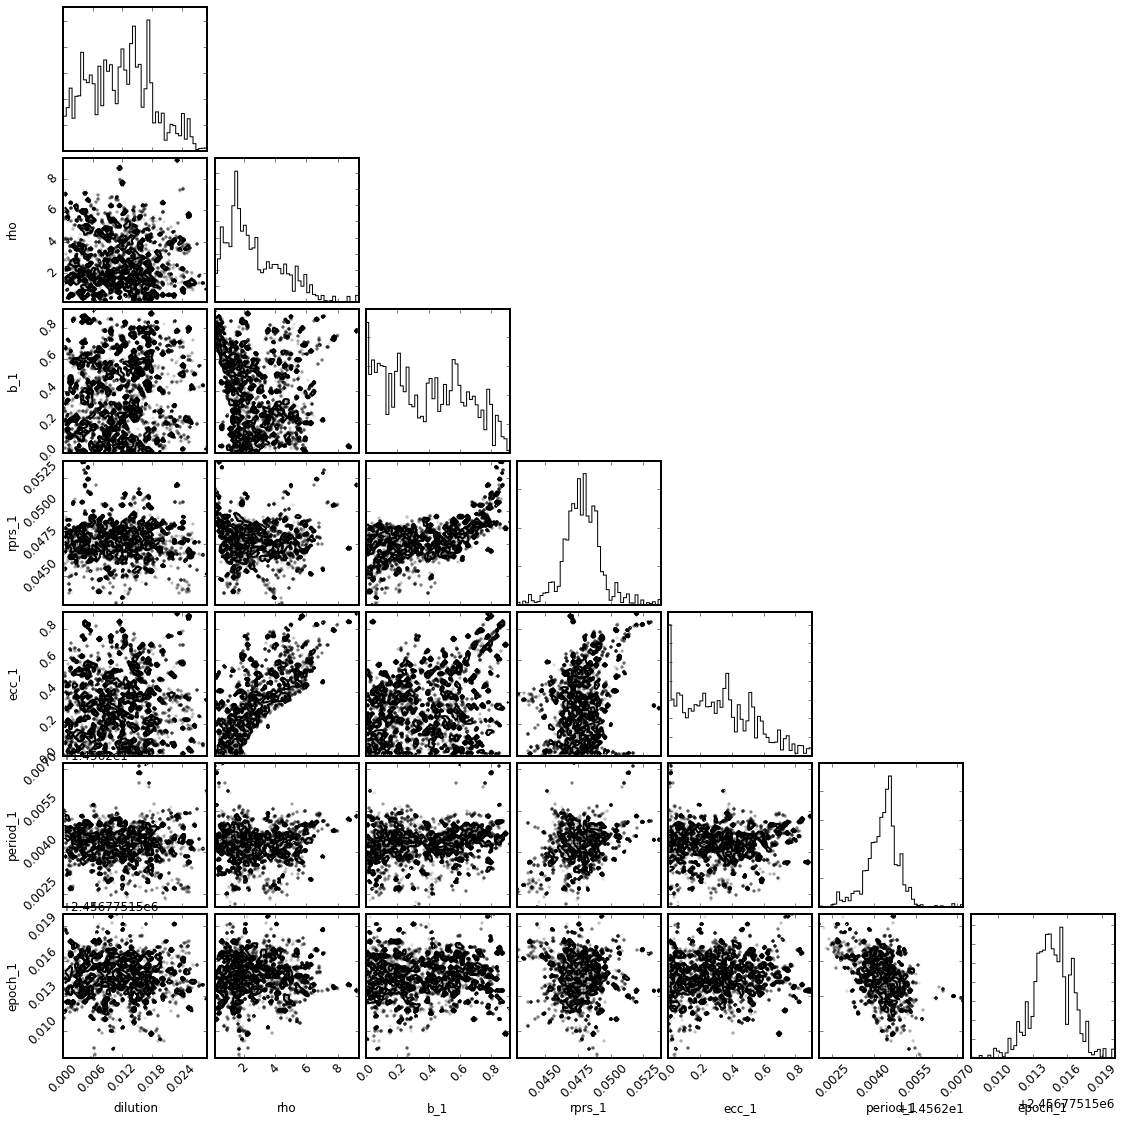

In [6]:
mod.triangle(['dilution', 'rho', 'b_1', 'rprs_1', 'ecc_1',
              'period_1', 'epoch_1']);

In [7]:
mod.samples[['period_1','epoch_1']].describe()

,period_1,epoch_1
count,20000.000000,20000.000000
mean,14.566310,2456775.164673
std,0.000592,0.028285
min,14.563970,2456775.155594
25%,14.565989,2456775.163617
50%,14.566373,2456775.164661
75%,14.566632,2456775.165751
max,14.569215,2456775.170220


Red flag:  larger-than-reported uncertainty in epoch.  Maybe slight TTVs?  Hard to tell by eye, but could be.

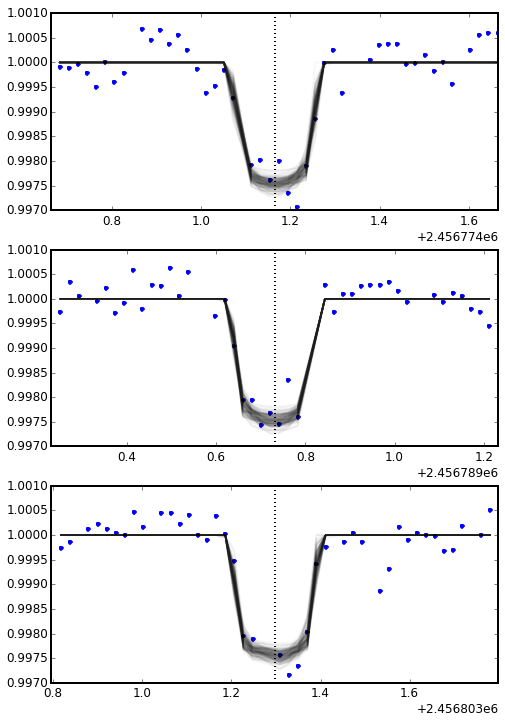

In [8]:
t0 = mod.samples['epoch_1'].mean()
P = mod.samples['period_1'].mean()
m1 = (t > t0-0.5) & (t < t0+0.5)
m2 = (t > t0+P-0.5) & (t < t0+P+0.5)
m3 = (t > t0+2*P-0.5) & (t < t0 + 2*P+0.5)

fig, axes = plt.subplots(3,1, figsize=(8,12))

for ax,m,n in zip(axes, [m1, m2, m3], [0,1,2]):
    ax.plot(t[m], f[m], '.');
    nsamples = 200
    inds = np.random.randint(len(mod.samples), size=nsamples)
    for _, s in mod.samples.iloc[inds].iterrows():
        fmod = mod.evaluate(tuple(s))
        ax.plot(t[m], fmod[m], 'k', alpha=0.03)
    ax.axvline(t0 + n*P, ls=':', color='k')
    ax.set_xlim(t0+n*P-0.5, t0+n*P+0.5)


Note some odd-looking residuals, especially around the first transit.  To be more comfortable about this I would like to see a systematics + transit fit, but that's beyond my scope for now.

OK, now, let's do a "fix-circular" fit, where we essentially don't let eccentricity vary (implemented as a very tight prior).

In [4]:
lc2 = LightCurve(t, f, f_err, texp=1626./86400, planets=[planet],
                detrend=False, 
                 dilution=(0.01, 0.005)) #dilution from paper, no rhostar
mod2 = TransitModel(lc2, fix_zp=True, fix_circular=True, width=3)

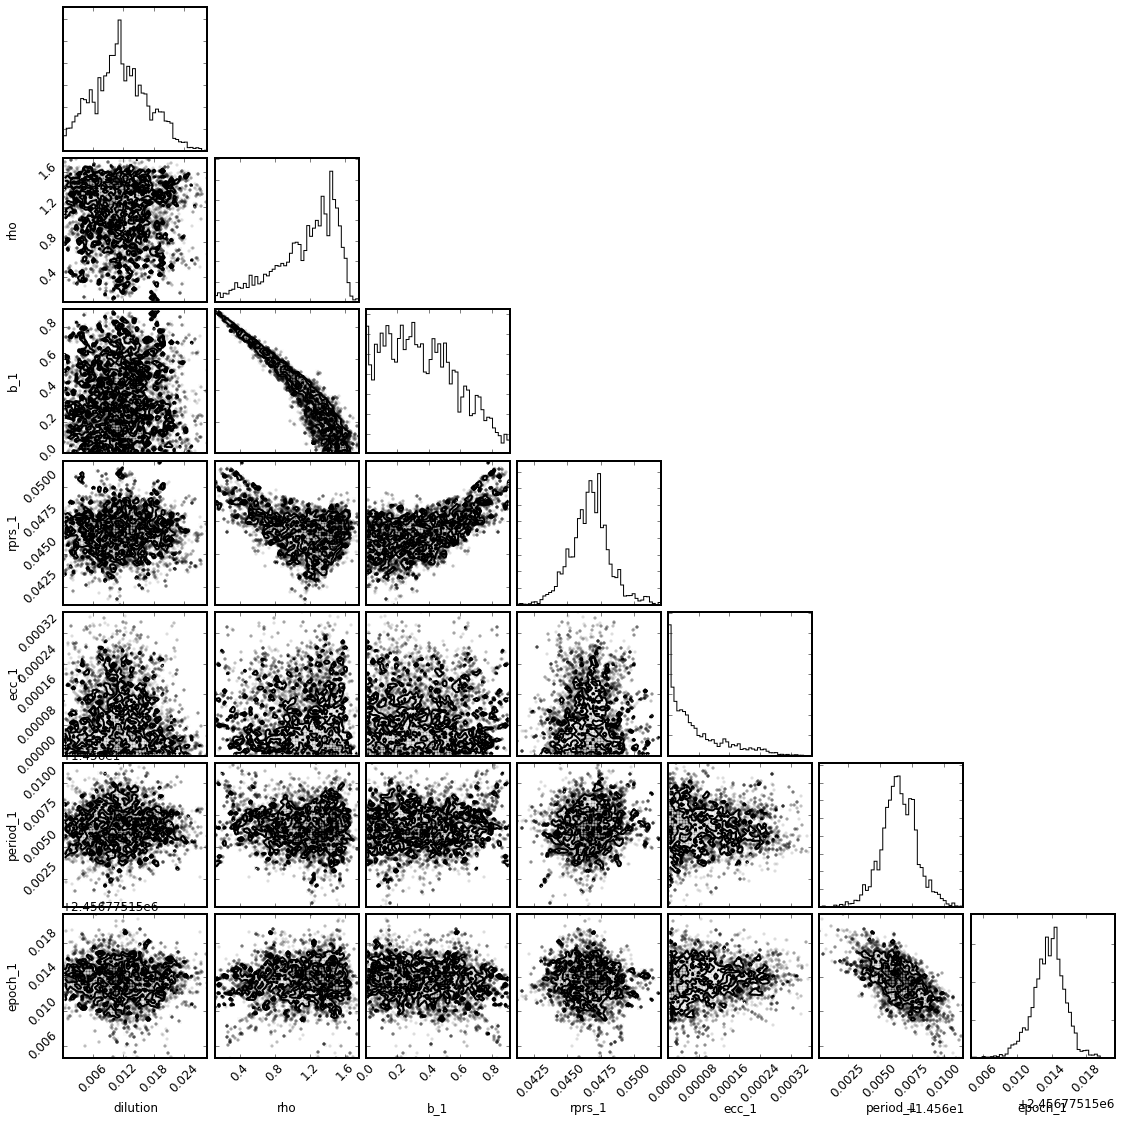

In [5]:
mod2.fit_emcee(nburn=300, niter=100);
mod2.triangle(['dilution', 'rho', 'b_1', 'rprs_1', 'ecc_1',
              'period_1', 'epoch_1']);

In [11]:
mod2.samples[['period_1','epoch_1']].describe()

,period_1,epoch_1
count,20000.000000,20000.000000
mean,14.566514,2456775.163648
std,0.001417,0.040001
min,14.558620,2456775.154205
25%,14.565666,2456775.162559
50%,14.566494,2456775.163754
75%,14.567450,2456775.164868
max,14.572412,2456775.172077


In [6]:
mod2.save_hdf('k2_circular_model.h5')